# TEP data analysis
In this notebook, we'll analyze the TEP extraction data. First, I've reformatted the data into a csv file that is easier to work with. The data consists of 3 replicates of TEP concentration measurements at 4 different stations, measured every hour for the longest possible time period depending on the weather and storm conditions. 

From the three replicates, the final TEP concentration is calculated as

$$TEP = (\frac{TEP_{1} + TEP_{2} + TEP_{3}}{3} - TEP_{blank}) * 56440 * 0,1$$

The blank that was taken at a given station is the first observation, and marked with _blank. Station 48 has no blank, so I added 0,1 as a blank value.


In [24]:
# Load necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sp

## Data pre-processing

In [25]:
data = pd.read_csv('../data/raw/TEP_data.csv', sep=';', decimal=',')
data.head()

,date,time,station,TEP_1,TEP_2,TEP_3
0,17-04-2023,13:00:00,W08_blank,0.087,0.113,0.129
1,17-04-2023,13:00:00,W08,0.260,0.262,0.262
2,17-04-2023,14:00,W08,0.131,0.181,0.190
3,17-04-2023,15:00:00,W08,0.141,0.193,0.220
4,17-04-2023,16:00,W08,0.123,0.146,0.208


In [26]:
def calculate_tep_concentration(tep_values, blank_avg, scale_factor=0.1):
    """
    Calculate the TEP concentration from replicate measurements of a sample and the average blank value taken at that station.

    Parameters:
        tep_values (list or tuple): Replicate measurements of TEP for the sample.
        blank_value (float): Mean of the replicate measurements of TEP for the blank.
        scale_factor (float, optional): The scaling factor for the final result (default is 0.1).

    Returns:
        float: The calculated TEP concentration.
    """
    # Calculate the average TEP values for sample and blank ignoring NaN values
    tep_avg = np.nanmean(tep_values)
    
    tep_concentration = (tep_avg - blank_avg) * 56440 * scale_factor
    return tep_concentration

In [27]:
# Extract the station name from 'station' column and create a new dataframe 'station_blank'
station_blank = data[data['station'].str.contains('blank')].copy()

# Calculate the mean TEP value of the blank stations
station_blank['TEP_avg'] = station_blank[['TEP_1', 'TEP_2', 'TEP_3']].mean(axis=1)

# Split _blank from the station name
station_blank['station'] = station_blank['station'].str.split('_blank').str[0]

# Remove the blanks from the original dataframe
data = data[~data['station'].str.contains('blank')]

# Reset the index of the original dataframe
data.reset_index(drop=True, inplace=True)

In [28]:
# Loop over the samples and add the calculated TEP to the dataframe
TEP = []
for i in range(len(data)):
    replicates = data.iloc[i][['TEP_1', 'TEP_2', 'TEP_3']].values
    blank = station_blank[station_blank['station'] == data.iloc[i]['station']]['TEP_avg'].astype(float).values[0]
    TEP.append(calculate_tep_concentration(tep_values = replicates, blank_avg = blank))
    
# Add the TEP values to the dataframe
data['TEP'] = TEP

In [29]:
# Merge date and time columns into one datetime column
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])

In [30]:
data.sort_values(by='TEP', ascending=False)

,date,time,station,TEP_1,TEP_2,TEP_3,TEP,datetime
53,20-04-2023,21:00,130,0.607,0.481,0.544,2250.074667,2023-04-20 21:00:00
48,20-04-2023,16:00,130,0.417,0.904,0.234,2105.212000,2023-04-20 16:00:00
46,20-04-2023,14:00,130,0.551,0.505,0.299,1728.945333,2023-04-20 14:00:00
60,21-04-2023,04:00,130,0.558,0.425,0.303,1599.133333,2023-04-21 04:00:00
50,20-04-2023,18:00,130,0.386,0.485,0.343,1463.677333,2023-04-20 18:00:00
...,...,...,...,...,...,...,...,...
13,18-04-2023,14:00,51,0.159,0.122,0.176,167.438667,2023-04-18 14:00:00
19,18-04-2023,20:00,51,0.111,0.171,0.172,161.794667,2023-04-18 20:00:00
34,19-04-2023,14:00,48,0.111,0.142,NaN,149.566000,2023-04-19 14:00:00
22,18-04-2023,23:00,51,0.129,0.150,0.166,144.862667,2023-04-18 23:00:00


## Visualization

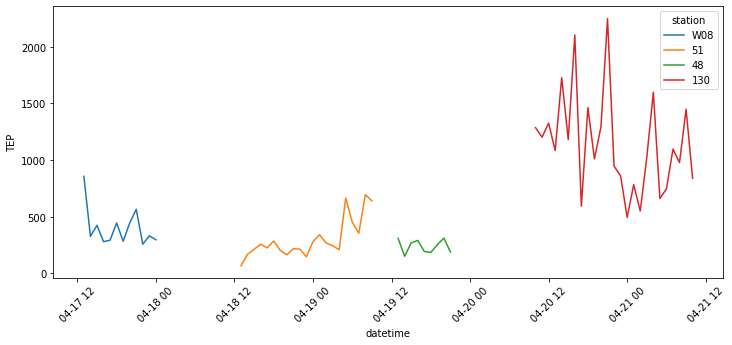

In [31]:
# Plot the average TEP concentration over time, coloured per station
## Initiate the plot
fig, ax = plt.subplots(figsize=(12, 5))
fig = sns.lineplot(x="datetime", y="TEP",
             hue="station",
             data=data)

# Adjust x axis labels
ax.tick_params(axis='x', rotation=45)

What is up with the data at station 130? Why these peaks and shifts? The variance is huge. Why?

In [32]:
# Plot the replicate TEP measurements per station, in 4 different plots. 
## Restructure the data, melt from wide to long format, with the columns: station, datetime, replicate, TEP
data_2 = data[['station', 'datetime', 'TEP_1', 'TEP_2', 'TEP_3']]
data_2 = data_2.melt(id_vars=['station', 'datetime'], value_vars=['TEP_1', 'TEP_2', 'TEP_3'], var_name='replicate', value_name='TEP')
data_2.head()

,station,datetime,replicate,TEP
0,W08,2023-04-17 13:00:00,TEP_1,0.260
1,W08,2023-04-17 14:00:00,TEP_1,0.131
2,W08,2023-04-17 15:00:00,TEP_1,0.141
3,W08,2023-04-17 16:00:00,TEP_1,0.123
4,W08,2023-04-17 17:00:00,TEP_1,0.136


In [33]:
# Divide the data into 4 dataframes, one for each station
df_130 = data_2[data_2['station'] == '130']
df_48 = data_2[data_2['station'] == '48']
df_51 = data_2[data_2['station'] == '51']
df_W08 = data_2[data_2['station'] == 'W08']

(0.0, 1.0)

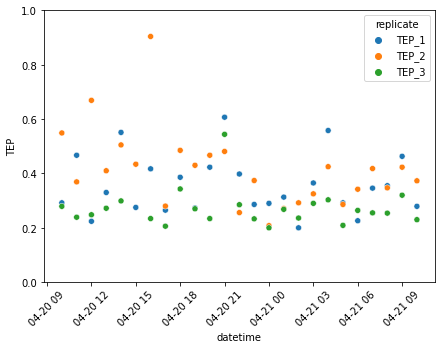

In [44]:
fig, ax = plt.subplots(figsize=(7, 5))

fig = sns.scatterplot(y='TEP', x='datetime', hue='replicate',
                      data=df_130)

# Adjust x axis labels
ax.tick_params(axis='x', rotation=45)

# Set y axis limits
ax.set_ylim(0, 1)

Ok. It looks like there's some outliers to this data, which are exaggerated after using the formula. Before calculation, let's do an outlier test and remove those samples.

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


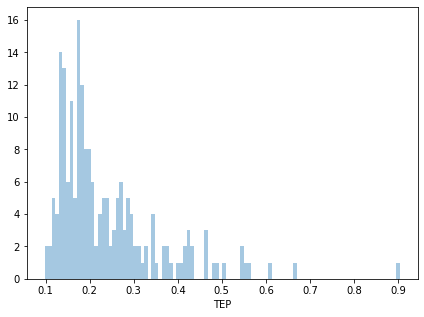

In [37]:
# Plot the distribution of the TEP values
fig, ax = plt.subplots(figsize=(7, 5))
fig = sns.distplot(data_2['TEP'], bins=100, kde=False, ax=ax)